# Movie Revenue Prediction

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from datetime import datetime as dt

# preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_transformer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ridge_regression
from sklearn.linear_model import LinearRegression

# tuning
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.model_selection import cross_val_score

from sklearn import metrics


### Configurations

In [2]:
plt.rcParams["figure.figsize"] = (20, 6)
plt.style.use("dark_background")
ENDDEL = "\n\t" + "---" * 15 + "\n"
pd.set_option("display.float_format", "{:,.0f}".format)


### Data Loading

In [3]:
def load_data(train):
    directory = "Training_data/" if train == True else "Testing_data/"
    directors = pd.read_csv(directory + "Prediction_data/movie-director.csv", header=0, names=["Movie_Title", "Director"])
    actors = pd.read_csv(
        directory + "Prediction_data/movie-voice-actors.csv", header=0, names=["Character", "Actor", "Movie_Title"]
    )
    revenues = pd.read_csv(
        directory + "Prediction_data/movies-revenue.csv",
        header=0,
        names=["Movie_Title", "Release_Date", "Genre", "MPAA_Rating", "Revenue"],
    )

    revenues.Revenue = pd.to_numeric(revenues.Revenue.str.replace(r"\D", "", regex=True))
    revenues.Release_Date = pd.to_datetime(revenues.Release_Date, format="%d-%b-%y")

    return pd.merge(directors, pd.merge(actors, revenues, on="Movie_Title", how="outer"), on="Movie_Title", how="outer")


original_data = load_data(True)
original_data.head()


,Movie_Title,Director,Character,Actor,Release_Date,Genre,MPAA_Rating,Revenue
0,Snow White and the Seven Dwarfs,David Hand,Bashful,Scotty Mattraw,2037-12-21,Musical,G,"5,228,953,251"
1,Snow White and the Seven Dwarfs,David Hand,Doc,Roy Atwell,2037-12-21,Musical,G,"5,228,953,251"
2,Snow White and the Seven Dwarfs,David Hand,Dopey,Eddie Collins,2037-12-21,Musical,G,"5,228,953,251"
3,Snow White and the Seven Dwarfs,David Hand,Grumpy,Pinto Colvig,2037-12-21,Musical,G,"5,228,953,251"
4,Snow White and the Seven Dwarfs,David Hand,Happy,Otis Harlan,2037-12-21,Musical,G,"5,228,953,251"


### Data Exploration

In [4]:
original_data.head()


,Movie_Title,Director,Character,Actor,Release_Date,Genre,MPAA_Rating,Revenue
0,Snow White and the Seven Dwarfs,David Hand,Bashful,Scotty Mattraw,2037-12-21,Musical,G,"5,228,953,251"
1,Snow White and the Seven Dwarfs,David Hand,Doc,Roy Atwell,2037-12-21,Musical,G,"5,228,953,251"
2,Snow White and the Seven Dwarfs,David Hand,Dopey,Eddie Collins,2037-12-21,Musical,G,"5,228,953,251"
3,Snow White and the Seven Dwarfs,David Hand,Grumpy,Pinto Colvig,2037-12-21,Musical,G,"5,228,953,251"
4,Snow White and the Seven Dwarfs,David Hand,Happy,Otis Harlan,2037-12-21,Musical,G,"5,228,953,251"


In [5]:
original_data.isna().sum()


Movie_Title       0
Director        714
Character       424
Actor           424
Release_Date    353
Genre           367
MPAA_Rating     458
Revenue         353
dtype: int64

In [6]:
original_data.describe()


,Revenue
count,897
mean,"256,307,552"
std,"636,767,911"
min,0
25%,"50,553,142"
50%,"119,860,589"
75%,"216,807,832"
max,"5,228,953,251"


In [7]:
print(original_data.Genre.unique(), end=ENDDEL)
print(original_data.MPAA_Rating.unique(), end=ENDDEL)
print(original_data.Director.unique(), end=ENDDEL)


['Musical' nan 'Drama' 'Adventure' 'Comedy' 'Romantic Comedy' 'Action'
 'Horror' 'Thriller/Suspense' 'Documentary' 'Black Comedy' 'Western'
 'Concert/Performance']
	---------------------------------------------
['G' nan 'PG' 'R' 'PG-13' 'Not Rated']
	---------------------------------------------
['David Hand' 'full credits' 'Ben Sharpsteen' 'Jack Kinney'
 'Norman Ferguson' 'Clyde Geronimi' 'Wilfred Jackson' 'Hamilton Luske'
 'Wolfgang Reitherman' 'Art Stevens' 'Ted Berman' 'Ron Clements'
 'Mike Gabriel' 'Gary Trousdale' 'Barry Cook' 'Chris Buck' 'Ralph Zondag'
 'Mark Dindal' 'Chris Sanders' 'Robert Walker' 'Will Finn'
 'Stephen J. Anderson' 'Nathan Greno' 'Rich Moore' 'Byron Howard' nan]
	---------------------------------------------


In [8]:
# Some dates are incorrectly parsed
original_data.Release_Date.describe(datetime_is_numeric=True)


count                              897
mean     2003-01-01 07:55:11.036789376
min                1970-04-24 00:00:00
25%                1992-11-11 00:00:00
50%                2000-11-22 00:00:00
75%                2009-11-25 00:00:00
max                2068-02-08 00:00:00
Name: Release_Date, dtype: object

4.054733724836276e+17

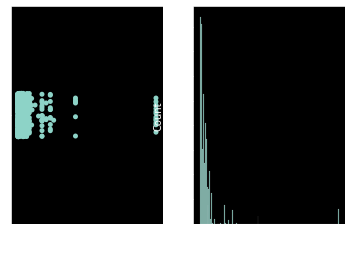

In [9]:
_, ax = plt.subplots(1, 2)
sb.stripplot(x=original_data.Revenue, ax=ax[0])
sb.histplot(x=original_data.Revenue, ax=ax[1])
# HUGE variance!
original_data.Revenue.var()


### Data Cleaning

In [10]:
original_data.dropna(subset=["Revenue"], inplace=True)
original_data.MPAA_Rating.fillna("Not Rated", inplace=True)
original_data.Director.fillna("Other", inplace=True)
original_data.Genre.fillna("Other", inplace=True)


In [11]:
original_data.isna().sum()
# original_data[original_data.Character.isna()]
# original_data[original_data.Actor.isna()]


Movie_Title       0
Director          0
Character       424
Actor           424
Release_Date      0
Genre             0
MPAA_Rating       0
Revenue           0
dtype: int64

In [12]:
# Fix incorrect year parsing
original_data.Release_Date = original_data.Release_Date.apply(
    lambda x: x.replace(year=x.year - 100 if x.year > dt.today().year else x.year)
)
original_data.Release_Date.describe(datetime_is_numeric=True)


count                              897
mean     1995-11-13 07:26:17.257525120
min                1937-12-21 00:00:00
25%                1990-11-16 00:00:00
50%                1998-06-19 00:00:00
75%                2007-03-30 00:00:00
max                2016-12-16 00:00:00
Name: Release_Date, dtype: object

#### Remove outliters

<AxesSubplot: xlabel='Revenue', ylabel='Count'>

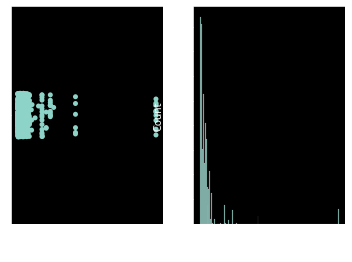

In [13]:
original_data.describe()
_, ax = plt.subplots(1, 2)
sb.stripplot(x=original_data.Revenue, ax=ax[0])
sb.histplot(x=original_data.Revenue, ax=ax[1])


<AxesSubplot: xlabel='Revenue', ylabel='Count'>

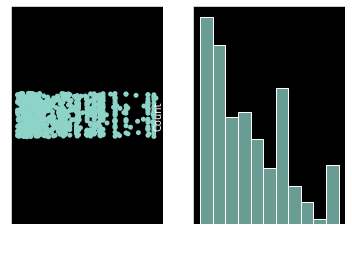

In [14]:
# Remove outliters
original_data = original_data[original_data.Revenue < original_data.Revenue.quantile(0.9)]
original_data.describe()

_, ax = plt.subplots(1, 2)
sb.stripplot(x=original_data.Revenue, ax=ax[0])
sb.histplot(x=original_data.Revenue, ax=ax[1])


### Feature Engineering

In [15]:
original_data = original_data.sample(frac=1).reset_index(drop=True)


In [16]:
release_day = original_data.Release_Date.dt.day
release_month = original_data.Release_Date.dt.month
release_year = original_data.Release_Date.dt.year

movie_age = dt.today().year - release_year


#### Correlations

In [17]:
print("movie_age correlation with revenue:", movie_age.corr(original_data.Revenue), end=ENDDEL)
print("release_day correlation with revenue:", release_day.corr(original_data.Revenue), end=ENDDEL)
print("release_month correlation with revenue:", release_month.corr(original_data.Revenue), end=ENDDEL)
print("release_year correlation with revenue:", release_year.corr(original_data.Revenue), end=ENDDEL)


movie_age correlation with revenue: -0.11051800516458292
	---------------------------------------------
release_day correlation with revenue: -0.1277397652908295
	---------------------------------------------
release_month correlation with revenue: -0.06450055108089721
	---------------------------------------------
release_year correlation with revenue: 0.11051800516458299
	---------------------------------------------


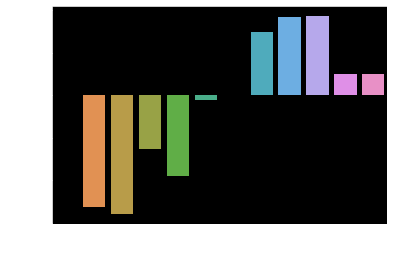

In [18]:
age_corr = dict()
for i in range(movie_age.min(), movie_age.max() + 5, 5):
    age_corr[i] = (movie_age >= i).corr(original_data.Revenue)

sb.barplot(x=list(age_corr.keys()), y=list(age_corr.values())).set(xlabel="Movie Age", ylabel="Revenue")
del age_corr


### Visualization

In [19]:
# Drop duplicate movies FOR VISUALIZATION
unique_records = original_data.drop_duplicates(subset=["Movie_Title"])
unique_records.shape

(436, 8)

#### [Genre, Director, MPAA_Rating] Frequencies

<AxesSubplot: title={'center': 'MPAA_Rating'}>

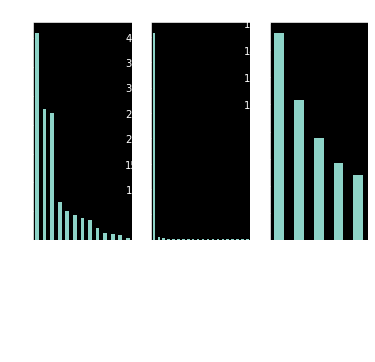

In [20]:
_, ax = plt.subplots(1, 3)
unique_records.Genre.value_counts().plot(ax=ax[0], kind="bar", title="Genre")
unique_records.Director.value_counts().plot(ax=ax[1], kind="bar", title="Director")
unique_records.MPAA_Rating.value_counts().plot(ax=ax[2], kind="bar", title="MPAA_Rating")


#### [Genre, Director, MPAA_Rating] VS Revenue

<AxesSubplot: title={'center': 'MPAA_Rating'}, xlabel='MPAA_Rating'>

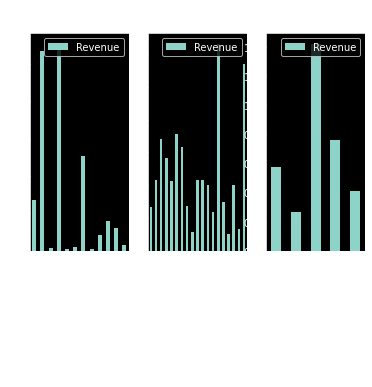

In [21]:
_, ax = plt.subplots(1, 3)

# dont consider 'other' genres
pd.pivot_table(
    unique_records[unique_records.Genre != "Other"],
    index="Genre",
    values="Revenue",
    aggfunc="sum",
).plot(kind="bar", ax=ax[0], title="Genres")

# dont consider 'other' directors
pd.pivot_table(
    unique_records[unique_records.Director != "Other"],
    index="Director",
    values="Revenue",
    aggfunc="sum",
).plot(kind="bar", ax=ax[1], title="Directors")

# dont consider 'Not Rated' movies
pd.pivot_table(
    unique_records[unique_records.Director != "Not Rated"],
    index="MPAA_Rating",
    values="Revenue",
    aggfunc="sum",
).plot(kind="bar", ax=ax[2], title="MPAA_Rating")


#### Movie Age Distribution

<AxesSubplot: xlabel='Release_Date', ylabel='Count'>

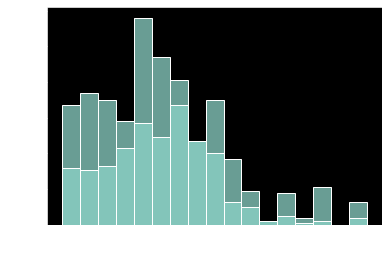

In [22]:
sb.histplot(movie_age)
sb.histplot(dt.today().year - unique_records.Release_Date.dt.year)


#### Movie Age VS Revenue

<AxesSubplot: xlabel='Release_Date', ylabel='Revenue'>

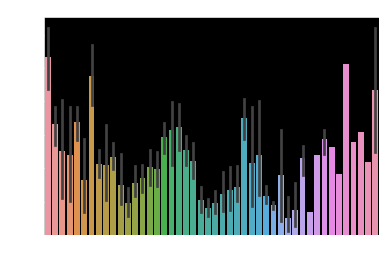

In [23]:
sb.barplot(x=movie_age, y=original_data.Revenue)


#### Cleanup

In [24]:
del unique_records, movie_age, release_day, release_year, release_month, ax


### Data Preprocessing

In [25]:
original_data.head()


,Movie_Title,Director,Character,Actor,Release_Date,Genre,MPAA_Rating,Revenue
0,The Little Mermaid,Ron Clements,Andrina,Tara Strong,1989-11-15,Adventure,G,"223,726,012"
1,Dinosaur,Ralph Zondag,Plio,Alfre Woodard,2000-05-19,Adventure,PG,"215,438,985"
2,DuckTales: The Movie - Treasure of th…,Other,NaN,NaN,1990-08-03,Adventure,G,"36,107,823"
3,Valiant,Other,NaN,NaN,2005-08-19,Adventure,G,"25,616,292"
4,Oscar,Other,NaN,NaN,1991-04-26,Comedy,PG,"47,181,395"


In [26]:
x_train = original_data[["Director", "MPAA_Rating", "Genre"]]
y_train = original_data.Revenue

x_train.describe()


,Director,MPAA_Rating,Genre
count,791,791,791
unique,20,5,13
top,Other,PG,Adventure
freq,423,294,377


### Basic Models

In [27]:
ohe_column_transformer = make_column_transformer(
    (OneHotEncoder(), ["Genre", "Director", "MPAA_Rating"]),
    remainder="drop",
    n_jobs=-1,
    sparse_threshold=0,
    verbose_feature_names_out=False,
)


In [ ]:
logistic_pipeline = make_pipeline(ohe_column_transformer, LogisticRegression(solver="lbfgs", max_iter=500))
logistic_pipeline.fit(x_train, y_train)

In [ ]:
linear_pipeline = make_pipeline(ohe_column_transformer, LinearRegression())
linear_pipeline.fit(x_train, y_train)


In [30]:
# ridge_pipeline = make_pipeline(ohe_column_transformer, ridge_regression(alpha=0.1, max_iter=1000))
# ridge_pipeline.fit(x_train, y_train)


### Ensemble Models

### Grid Search

### Models Testing

#### Loading test data

In [31]:
test_data = load_data(False)
test_data.Release_Date = original_data.Release_Date.apply(
    lambda x: x.replace(year=x.year - 100 if x.year > dt.today().year else x.year)
)


#### Preprocessing test data

In [32]:
test_data.MPAA_Rating.fillna("Not Rated", inplace=True)
test_data.Director.fillna("Other", inplace=True)


In [33]:
# x_test = test_data[["Director", "MPAA_Rating", "Genre"]]

y_test = test_data.Revenue


#### Evaluation

##### Logistic Regression

In [34]:
y_predict = logistic_pipeline.predict(test_data)
metrics.mean_squared_error(y_test, y_predict)


1.1896196497853728e+16

In [35]:
for i, j in zip(y_predict, y_test):
    print(i, j, i - j)


159743914.0 258728898 -98984984.0
159743914.0 258728898 -98984984.0
159743914.0 258728898 -98984984.0
159743914.0 258728898 -98984984.0
159743914.0 258728898 -98984984.0
159743914.0 258728898 -98984984.0
159743914.0 258728898 -98984984.0
159743914.0 258728898 -98984984.0
68479579.0 24333094 44146485.0
201151353.0 4609153 196542200.0


##### Linear Regression

In [36]:
y_predict = linear_pipeline.predict(test_data)
metrics.mean_squared_error(y_test, y_predict)


1.0220378730483988e+16

In [37]:
for i, j in zip(y_predict, y_test):
    print(i, j, i - j)


147324928.0 258728898 -111403970.0
147324928.0 258728898 -111403970.0
147324928.0 258728898 -111403970.0
147324928.0 258728898 -111403970.0
147324928.0 258728898 -111403970.0
147324928.0 258728898 -111403970.0
147324928.0 258728898 -111403970.0
147324928.0 258728898 -111403970.0
68157440.0 24333094 43824346.0
36175872.0 4609153 31566719.0
